# Testing LDA, QDA, Naive Bayes with iris dataset

## Testing LDA

In [4]:
import numpy as np
from visualize_iris import visualize_iris
from sklearn.datasets import load_iris
from LDA import LDAClassifier
from QDA import QDAClassifier
from NaiveBayes import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
# Load the data
data = load_iris()
X = data.data
Y = data.target

In [6]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [7]:
# Initialize the model
model = LDAClassifier()
model.fit(X_train, Y_train)
model.predict(X_test)

[1. 0. 1. 1. 1. 0. 1. 2. 1. 1. 2. 0. 0. 0. 0. 2. 2. 1. 1. 2. 0. 2. 0. 2.
 2. 2. 1. 2. 0. 0.]


array([1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 2., 0., 0., 0., 0., 2., 2.,
       1., 1., 2., 0., 2., 0., 2., 2., 2., 1., 2., 0., 0.])

In [8]:
model.score(Y_test)

0.9


In [9]:
# Compare with sklearn model
sk_model = LinearDiscriminantAnalysis()
sk_model.fit(X_train, Y_train)
sk_model.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

In [10]:
sk_model.score(X_test, Y_test)

1.0

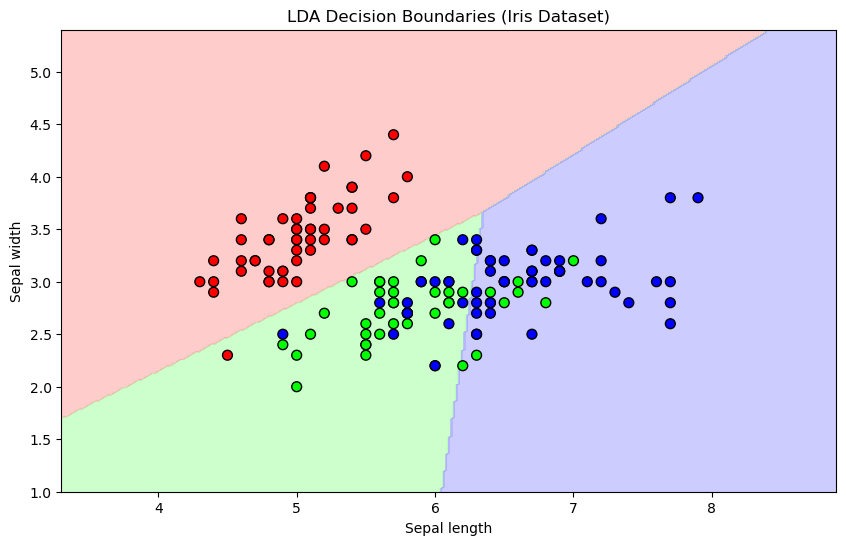

In [11]:
visualize_iris(data, sk_model, title = 'LDA Decision Boundaries (Iris Dataset)')

### Testing QDA

In [13]:
qda_model = QDAClassifier()
qda_model.fit(X_train, Y_train)
qda_model.predict(X_test)

[1. 0. 2. 1. 1. 0. 1. 2. 2. 1. 2. 0. 0. 0. 0. 1. 2. 1. 1. 2. 0. 2. 0. 2.
 2. 2. 2. 2. 0. 0.]


array([1., 0., 2., 1., 1., 0., 1., 2., 2., 1., 2., 0., 0., 0., 0., 1., 2.,
       1., 1., 2., 0., 2., 0., 2., 2., 2., 2., 2., 0., 0.])

In [14]:
qda_model.score(Y_test)

0.9666666666666667


[1. 1. 1. ... 2. 2. 2.]


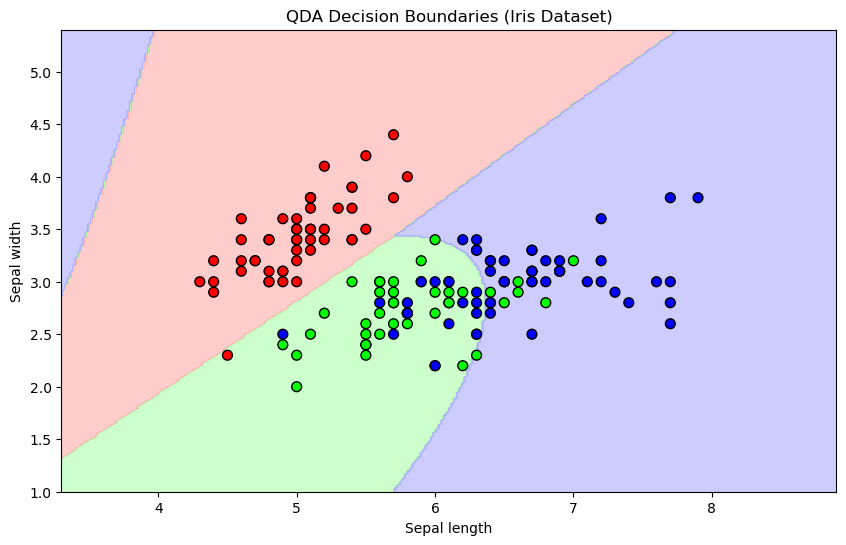

In [15]:
visualize_iris(data, qda_model, title = 'QDA Decision Boundaries (Iris Dataset)')

### Testing Naive Bayes

In [32]:
nb_model = NaiveBayesClassifier()
nb_model.fit(X_train, Y_train)
predictions = nb_model.predict(X_test)
predictions

array([1., 0., 2., 1., 1., 0., 1., 2., 1., 1., 2., 0., 0., 0., 0., 1., 2.,
       1., 1., 2., 0., 2., 0., 2., 2., 2., 2., 2., 0., 0.])

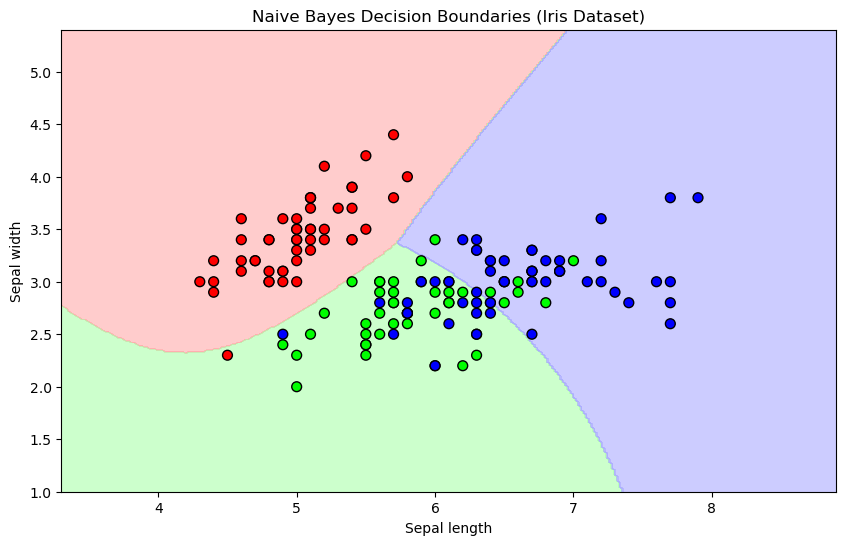

In [34]:
visualize_iris(data, nb_model, title = 'Naive Bayes Decision Boundaries (Iris Dataset)')

In [36]:
nb_model.score(predictions, Y_test)

1.0

In [45]:
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml


class BayesianBandit:
    """
    Bayesian Bandit Hyperparameter Optimization using Gaussian Processes
    with Upper Confidence Bound (UCB) acquisition function
    """
    
    def __init__(self, parameter_bounds, n_init=5, kappa=2.5):
        """
        Initialize the Bayesian Bandit optimizer
        
        Args:
            parameter_bounds (dict): Dictionary of parameter names and their bounds (min, max)
            n_init (int): Number of random initialization points
            kappa (float): Exploration-exploitation trade-off parameter for UCB
        """
        self.parameter_bounds = parameter_bounds
        self.params = list(parameter_bounds.keys())
        self.n_params = len(parameter_bounds)
        self.n_init = n_init
        self.kappa = kappa
        
        # Initialize GP with Matern kernel (better for hyperparameter optimization)
        self.kernel = Matern(nu=2.5)
        self.gp = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=1e-6,  # Small noise for numerical stability
            normalize_y=True,
            n_restarts_optimizer=10,
            random_state=42
        )
        
        # History of parameter values and their performance
        self.X_sample = np.empty((0, self.n_params))
        self.y_sample = np.empty((0,))
        
        # Best parameters and score
        self.best_params = None
        self.best_score = -np.inf
        
    def _sample_random_params(self):
        """Sample random parameters within given bounds"""
        params = {}
        for param_name, bounds in self.parameter_bounds.items():
            params[param_name] = np.random.uniform(bounds[0], bounds[1])
        return params
    
    def _convert_params_to_array(self, params):
        """Convert dictionary of parameters to numpy array"""
        return np.array([params[param] for param in self.params]).reshape(1, -1)
    
    def _convert_array_to_params(self, x):
        """Convert numpy array to dictionary of parameters"""
        return {param: x[i] for i, param in enumerate(self.params)}
    
    def _ucb(self, x, gp, kappa):
        """Upper Confidence Bound acquisition function"""
        mean, std = gp.predict(x.reshape(1, -1), return_std=True)
        return mean + kappa * std
    
    def _get_next_params(self):
        """Get the next parameters to evaluate using UCB acquisition function"""
        # If not enough samples, use random exploration
        if len(self.y_sample) < self.n_init:
            return self._sample_random_params()
            
        # Update GP with current data
        self.gp.fit(self.X_sample, self.y_sample)
        
        # Use random search to maximize acquisition function
        best_acquisition = -np.inf
        best_params = None
        
        # Number of random samples to try for acquisition optimization
        n_samples = 10000
        
        # Generate random samples within parameter bounds
        X_random = np.random.uniform(
            low=[self.parameter_bounds[param][0] for param in self.params],
            high=[self.parameter_bounds[param][1] for param in self.params],
            size=(n_samples, self.n_params)
        )
        
        # Evaluate acquisition function for all samples
        acquisition_values = np.array([
            self._ucb(x, self.gp, self.kappa) for x in X_random
        ]).flatten()
        
        # Find the best sample
        best_idx = np.argmax(acquisition_values)
        best_params_array = X_random[best_idx]
        
        # Convert to dictionary
        best_params = self._convert_array_to_params(best_params_array)
        
        return best_params
    
    def update(self, params, score):
        """Update the optimizer with new evaluation results"""
        # Convert params to array
        x = self._convert_params_to_array(params)
        
        # Update samples
        self.X_sample = np.vstack((self.X_sample, x))
        self.y_sample = np.append(self.y_sample, score)
        
        # Update best parameters and score
        if score > self.best_score:
            self.best_score = score
            self.best_params = params.copy()
    
    def get_next_params(self):
        """Get the next parameters to evaluate"""
        return self._get_next_params()
    
    def get_best_params(self):
        """Get the best parameters found so far"""
        return self.best_params, self.best_score
    
    def plot_optimization_history(self):
        """Plot the optimization history"""
        plt.figure(figsize=(12, 5))
        
        # Plot performance over iterations
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.y_sample) + 1), self.y_sample, 'o-', label='Observed Performance')
        plt.axhline(y=self.best_score, color='r', linestyle='--', label=f'Best Score: {self.best_score:.4f}')
        plt.xlabel('Iteration')
        plt.ylabel('Validation Accuracy')
        plt.title('Optimization Progress')
        plt.legend()
        
        # Plot cumulative maximum
        cummax = np.maximum.accumulate(self.y_sample)
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cummax) + 1), cummax, 'g-', label='Cumulative Maximum')
        plt.xlabel('Iteration')
        plt.ylabel('Best Score Found')
        plt.title('Convergence Plot')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def plot_parameter_importance(self):
        """Plot the estimated importance of each parameter"""
        if len(self.y_sample) < 5:
            print("Not enough samples to analyze parameter importance")
            return
            
        # Fit the GP to the data
        self.gp.fit(self.X_sample, self.y_sample)
        
        # Generate a grid of test points for each parameter
        n_test_points = 100
        importance_scores = []
        
        # For each parameter, vary it while keeping others at their mean
        for i, param in enumerate(self.params):
            # Get mean values for all parameters
            mean_values = np.mean(self.X_sample, axis=0)
            
            # Create test points by varying only the current parameter
            test_points = np.tile(mean_values, (n_test_points, 1))
            param_range = np.linspace(
                self.parameter_bounds[param][0],
                self.parameter_bounds[param][1],
                n_test_points
            )
            test_points[:, i] = param_range
            
            # Predict mean and std at test points
            means, stds = self.gp.predict(test_points, return_std=True)
            
            # Importance score is the range of predicted values
            importance = np.max(means) - np.min(means)
            importance_scores.append(importance)
        
        # Plot parameter importance
        plt.figure(figsize=(10, 6))
        sorted_idx = np.argsort(importance_scores)
        plt.barh(range(len(importance_scores)), 
                [importance_scores[i] for i in sorted_idx])
        plt.yticks(range(len(importance_scores)), 
                  [self.params[i] for i in sorted_idx])
        plt.xlabel('Estimated Importance')
        plt.title('Parameter Importance Analysis')
        plt.tight_layout()
        plt.show()


def test_bayesian_bandit_mnist_mlp():
    """Test Bayesian Bandit optimization on MNIST with MLP Classifier"""
    print("Loading MNIST dataset...")
    
    # Load MNIST dataset
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    X = X.astype(float) / 255.0  # Convert to float and scale features to [0, 1]
    y = y.astype(str)  # Ensure labels are strings
    
    # Convert to numpy arrays
    X = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)
    
    # Split the data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # To save computation time, use a subset of the data
    # This is optional but can speed up the optimization process
    sample_size = 5000
    if X_train.shape[0] > sample_size:
        idx = np.random.choice(X_train.shape[0], sample_size, replace=False)
        X_train_sample = X_train[idx]
        y_train_sample = y_train[idx]
    else:
        X_train_sample = X_train
        y_train_sample = y_train
    
    if X_val.shape[0] > sample_size // 5:
        idx = np.random.choice(X_val.shape[0], sample_size // 5, replace=False)
        X_val_sample = X_val[idx]
        y_val_sample = y_val[idx]
    else:
        X_val_sample = X_val
        y_val_sample = y_val
    
    print(f"Using {X_train_sample.shape[0]} samples for training")
    print(f"Using {X_val_sample.shape[0]} samples for validation")
    
    # Define a function to evaluate hyperparameters
    def evaluate_params(params):
        """Evaluate hyperparameters using MLPClassifier and measure validation accuracy"""
        # Convert continuous parameters to discrete where needed
        hidden_layer_1 = int(params['hidden_layer_1'])
        hidden_layer_2 = int(params['hidden_layer_2'])
        hidden_layers = (hidden_layer_1, hidden_layer_2)
        
        # Determine activation function
        activation_value = params['activation']
        if activation_value < 0.33:
            activation = 'relu'
        elif activation_value < 0.66:
            activation = 'tanh'
        else:
            activation = 'logistic'
        
        # Determine solver
        solver_value = params['solver']
        if solver_value < 0.33:
            solver = 'adam'
        elif solver_value < 0.66:
            solver = 'sgd'
        else:
            solver = 'lbfgs'
        
        # Create and train the MLP classifier
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation=activation,
            solver=solver,
            alpha=params['alpha'],  # L2 regularization
            learning_rate_init=params['learning_rate'],
            batch_size=int(params['batch_size']),
            max_iter=100,  # Limit iterations for faster evaluation
            random_state=42
        )
        
        mlp.fit(X_train_sample, y_train_sample)
        
        # Evaluate on validation set
        val_accuracy = mlp.score(X_val_sample, y_val_sample)
        
        return val_accuracy
    
    # Define parameter bounds for MLP
    parameter_bounds = {
        'hidden_layer_1': (50, 300),       # Number of neurons in first hidden layer
        'hidden_layer_2': (50, 300),       # Number of neurons in second hidden layer
        'alpha': (0.0001, 0.01),           # L2 regularization parameter
        'learning_rate': (0.0001, 0.1),    # Initial learning rate
        'batch_size': (32, 256),           # Batch size
        'activation': (0, 1),              # Encoded as range: relu, tanh, logistic
        'solver': (0, 1)                   # Encoded as range: adam, sgd, lbfgs
    }
    
    # Initialize Bayesian Bandit optimizer
    optimizer = BayesianBandit(parameter_bounds, n_init=5, kappa=2.5)
    
    # Number of iterations
    n_iterations = 20
    
    # Run optimization
    start_time = time.time()
    
    print("\nStarting Bayesian Bandit Optimization for MNIST MLP...")
    for i in range(n_iterations):
        iteration_start = time.time()
        
        # Get next parameters to evaluate
        params = optimizer.get_next_params()
        
        # Print current parameters being evaluated
        print(f"\nIteration {i+1}/{n_iterations}")
        print("Evaluating parameters:")
        for k, v in params.items():
            if k in ['hidden_layer_1', 'hidden_layer_2', 'batch_size']:
                print(f"  {k}: {int(v)}")
            elif k == 'activation':
                act_name = 'relu' if v < 0.33 else 'tanh' if v < 0.66 else 'logistic'
                print(f"  {k}: {v:.4f} ({act_name})")
            elif k == 'solver':
                solver_name = 'adam' if v < 0.33 else 'sgd' if v < 0.66 else 'lbfgs'
                print(f"  {k}: {v:.4f} ({solver_name})")
            else:
                print(f"  {k}: {v:.6f}")
        
        # Evaluate parameters
        print("Training model...")
        score = evaluate_params(params)
        
        # Update optimizer with results
        optimizer.update(params, score)
        
        # Print results
        print(f"Validation accuracy: {score:.4f}")
        
        best_params, best_score = optimizer.get_best_params()
        print(f"Best accuracy so far: {best_score:.4f}")
        
        iteration_time = time.time() - iteration_start
        print(f"Iteration time: {iteration_time:.2f} seconds")
        print("-" * 50)
    
    # Calculate and print total time taken
    end_time = time.time()
    print(f"\nTotal optimization time: {end_time - start_time:.2f} seconds")
    
    # Get final best parameters and score
    best_params, best_score = optimizer.get_best_params()
    
    print("\nOptimization Complete!")
    print(f"Best Validation Accuracy: {best_score:.4f}")
    print("\nBest Parameters:")
    for k, v in best_params.items():
        if k in ['hidden_layer_1', 'hidden_layer_2', 'batch_size']:
            print(f"  {k}: {int(v)}")
        elif k == 'activation':
            act_name = 'relu' if v < 0.33 else 'tanh' if v < 0.66 else 'logistic'
            print(f"  {k}: {v:.4f} ({act_name})")
        elif k == 'solver':
            solver_name = 'adam' if v < 0.33 else 'sgd' if v < 0.66 else 'lbfgs'
            print(f"  {k}: {v:.4f} ({solver_name})")
        else:
            print(f"  {k}: {v:.6f}")
    
    # Plot optimization history and parameter importance
    optimizer.plot_optimization_history()
    optimizer.plot_parameter_importance()
    
    # Train and evaluate final model with best parameters on full dataset
    print("\nTraining final model with best parameters on full dataset...")
    
    # Extract the best parameters
    hidden_layer_1 = int(best_params['hidden_layer_1'])
    hidden_layer_2 = int(best_params['hidden_layer_2'])
    hidden_layers = (hidden_layer_1, hidden_layer_2)
    
    activation_value = best_params['activation']
    if activation_value < 0.33:
        activation = 'relu'
    elif activation_value < 0.66:
        activation = 'tanh'
    else:
        activation = 'logistic'
    
    solver_value = best_params['solver']
    if solver_value < 0.33:
        solver = 'adam'
    elif solver_value < 0.66:
        solver = 'sgd'
    else:
        solver = 'lbfgs'
    
    final_model = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        alpha=best_params['alpha'],
        learning_rate_init=best_params['learning_rate'],
        batch_size=int(best_params['batch_size']),
        max_iter=200,  # Allow more iterations for final training
        random_state=42
    )
    
    final_model.fit(X_train, y_train)
    test_accuracy = final_model.score(X_test, y_test)
    
    print(f"\nTest accuracy with best parameters: {test_accuracy:.4f}")
    
    # Train a model with default parameters for comparison
    print("\nTraining model with default parameters for comparison...")
    default_model = MLPClassifier(
        hidden_layer_sizes=(100,),  # Default is one layer with 100 neurons
        random_state=42
    )
    
    default_model.fit(X_train, y_train)
    default_test_accuracy = default_model.score(X_test, y_test)
    
    print(f"\nTest accuracy with default parameters: {default_test_accuracy:.4f}")
    print(f"Improvement: {(test_accuracy - default_test_accuracy) * 100:.2f}%")


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Run the test
    test_bayesian_bandit_mnist_mlp()

Loading MNIST dataset...
Training data shape: (44800, 784)
Validation data shape: (11200, 784)
Test data shape: (14000, 784)
Using 5000 samples for training
Using 1000 samples for validation

Starting Bayesian Bandit Optimization for MNIST MLP...

Iteration 1/20
Evaluating parameters:
  hidden_layer_1: 193
  hidden_layer_2: 151
  alpha: 0.008508
  learning_rate: 0.041632
  batch_size: 131
  activation: 0.5922 (tanh)
  solver: 0.1232 (adam)
Training model...
Validation accuracy: 0.7520
Best accuracy so far: 0.7520
Iteration time: 38.28 seconds
--------------------------------------------------

Iteration 2/20
Evaluating parameters:
  hidden_layer_1: 89
  hidden_layer_2: 247
  alpha: 0.002807
  learning_rate: 0.068501
  batch_size: 53
  activation: 0.8218 (logistic)
  solver: 0.9882 (lbfgs)
Training model...
Validation accuracy: 0.9180
Best accuracy so far: 0.9180
Iteration time: 42.86 seconds
--------------------------------------------------

Iteration 3/20
Evaluating parameters:
  hid

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy: 0.9460
Best accuracy so far: 0.9460
Iteration time: 208.50 seconds
--------------------------------------------------

Iteration 4/20
Evaluating parameters:
  hidden_layer_1: 145
  hidden_layer_2: 104
  alpha: 0.002473
  learning_rate: 0.080066
  batch_size: 46
  activation: 0.5638 (tanh)
  solver: 0.3068 (adam)
Training model...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy: 0.0980
Best accuracy so far: 0.9460
Iteration time: 5.94 seconds
--------------------------------------------------

Iteration 5/20
Evaluating parameters:
  hidden_layer_1: 116
  hidden_layer_2: 176
  alpha: 0.008989
  learning_rate: 0.061847
  batch_size: 208
  activation: 0.6007 (tanh)
  solver: 0.6977 (lbfgs)
Training model...


KeyboardInterrupt: 